In [2]:
import os
import copy
import numpy as np
from scipy.integrate import quad
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from decimal import Decimal, getcontext
sns.set()

# Set decimal precision
getcontext().prec = 100

In [3]:
global_seed = 42

In [4]:
def _gaussian(x, mu, sigma):
    return Decimal(1) / Decimal(np.sqrt(2 * np.pi * sigma**2)) * np.exp(-Decimal((x - mu) ** 2) / Decimal(2 * sigma ** 2))

def mixture_of_gaussian(x, mus:List=[0], sigmas:List=[1.], weights:List=[1.]):
    assert len(mus) == len(sigmas) == len(weights)
    assert np.sum(weights) == 1.
    
    mog = np.asarray([Decimal(weights[i]) * _gaussian(x, mus[i], sigmas[i]) for i in range(len(weights))])

    return np.sum(mog, axis=0)

def importance_sampling_variance(x, p_args, q_args, v):

    p = mixture_of_gaussian(x, **p_args)
    q = mixture_of_gaussian(x, **q_args)

    return ((Decimal(p) / Decimal(q)) - Decimal(v))**2 * Decimal(q)

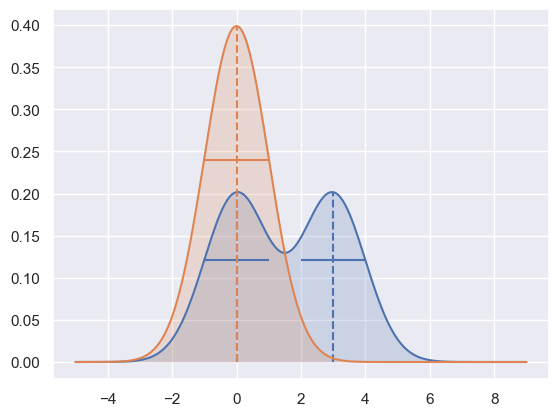

In [5]:
linspace = np.linspace(-5, 9, 200)
p_args = {"mus": [0, 3], "sigmas": [1, 1], "weights": [0.5, 0.5]}
q_args = {"mus": [0], "sigmas": [1]}

p = np.asarray([float(mixture_of_gaussian(x, **p_args)) for x in linspace])
q = np.asarray([float(mixture_of_gaussian(x, **q_args)) for x in linspace])

plt.plot(linspace, p)
plt.fill_between(linspace, p, np.zeros_like(p), alpha=0.2)
plt.vlines(x=p_args["mus"][0], ymin=0, ymax = mixture_of_gaussian(p_args["mus"][0], **p_args), colors="C0", linestyles="dashed")
plt.hlines(y=mixture_of_gaussian(p_args["mus"][0], **p_args) / 5 * 3, 
           xmin=p_args["mus"][0] - p_args["sigmas"][0], 
           xmax=p_args["mus"][0] + p_args["sigmas"][0], colors="C0")
plt.vlines(x=p_args["mus"][1], ymin=0, ymax = mixture_of_gaussian(p_args["mus"][1], **p_args), colors="C0", linestyles="dashed")
plt.hlines(y=mixture_of_gaussian(p_args["mus"][1], **p_args) / 5 * 3, 
           xmin=p_args["mus"][1] - p_args["sigmas"][1], 
           xmax=p_args["mus"][1] + p_args["sigmas"][1], colors="C0")
plt.plot(linspace, q)
plt.fill_between(linspace, q, np.zeros_like(q), alpha=0.2)
plt.vlines(x=q_args["mus"][0], ymin=0, ymax = mixture_of_gaussian(q_args["mus"][0], **q_args), colors="C1", linestyles="dashed")
plt.hlines(y=mixture_of_gaussian(q_args["mus"][0], **q_args) / 5 * 3, 
           xmin=q_args["mus"][0] - q_args["sigmas"][0], 
           xmax=q_args["mus"][0] + q_args["sigmas"][0], colors="C1")
plt.show()

In [6]:
# set bound for numerical integration
int_bound = 1e3

# test on standard gaussians shown above
print(quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v_ for v_ in p_args.values()]))[0])
print(quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v_ for v_ in q_args.values()]))[0])

v = quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v_ for v_ in p_args.values()]))[0]
print(v)

# variance of IS estimate
print(quad(importance_sampling_variance, -int_bound, int_bound, args=(p_args, q_args, v))[0])

1.0000000000000002
1.0
1.0000000000000002
2025.520981893846


In [7]:
p_sigma_ablation = np.linspace(0.1, 1.3, 100)
p_sigma_ablation_variances = list()

for sigma_a in tqdm(p_sigma_ablation):
    p_args_ = copy.deepcopy(p_args)
    p_args_["sigmas"][1] = sigma_a

    v = quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v for v in p_args_.values()]))[0]

    variance = quad(importance_sampling_variance, -int_bound, int_bound, args=(p_args_, q_args, v))[0]
    p_sigma_ablation_variances.append(variance)


mu_ablation = np.linspace(0.5, 5, 100)
mu_ablation_variances = list()

for mu_a in tqdm(mu_ablation):
    p_args_ = copy.deepcopy(p_args)
    p_args_["mus"][1] = mu_a

    v = quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v for v in p_args_.values()]))[0]

    variance = quad(importance_sampling_variance, -int_bound, int_bound, args=(p_args_, q_args, v))[0]
    mu_ablation_variances.append(variance)


q_sigma_ablation = np.linspace(0.8, 5, 100)
q_sigma_ablation_variances = list()

for sigma_a in tqdm(q_sigma_ablation):
    q_args_ = copy.deepcopy(q_args)
    q_args_["sigmas"][0] = sigma_a

    v = quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v for v in p_args.values()]))[0]

    variance = quad(importance_sampling_variance, -int_bound, int_bound, args=(p_args, q_args_, v))[0]
    q_sigma_ablation_variances.append(variance)

p_ablation = np.linspace(0, 1, 100)
p_ablation_variances = list()

for p_ in tqdm(p_ablation):
    p_args_ = copy.deepcopy(p_args)
    p_args_["weights"][0] = 1 - p_
    p_args_["weights"][1] = p_

    v = quad(mixture_of_gaussian, -int_bound, int_bound, args=tuple([v for v in p_args_.values()]))[0]

    variance = quad(importance_sampling_variance, -int_bound, int_bound, args=(p_args_, q_args, v))[0]
    p_ablation_variances.append(variance)

100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


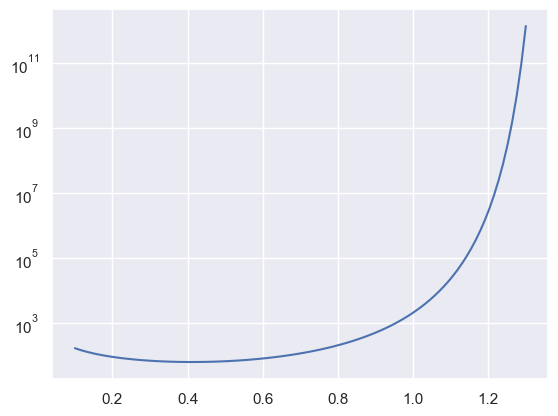

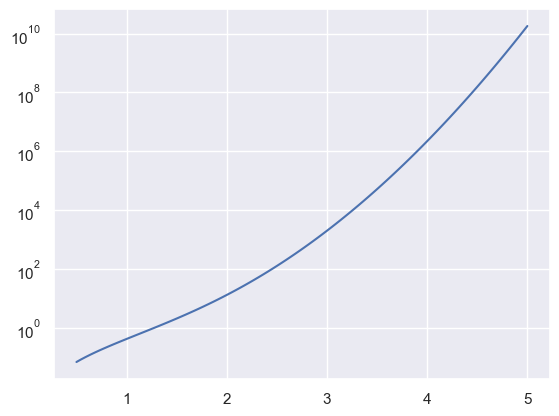

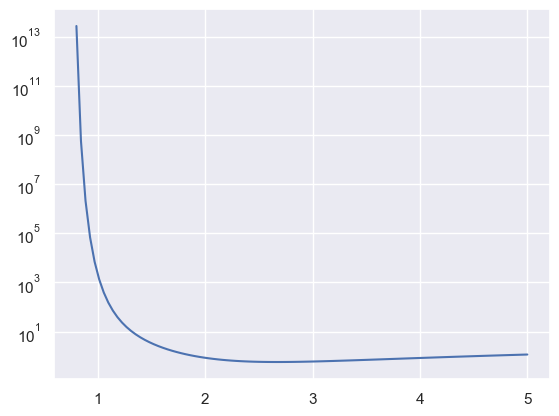

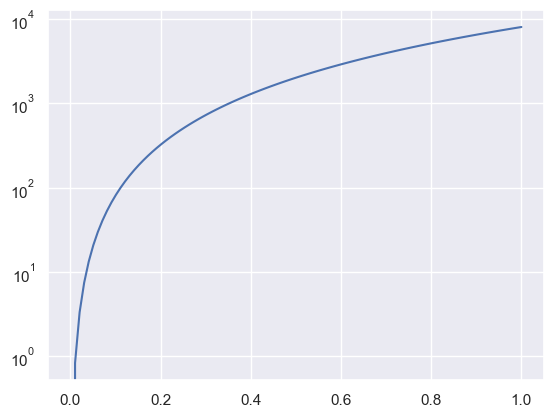

In [8]:
plt.plot(p_sigma_ablation, p_sigma_ablation_variances)
plt.yscale("log")
plt.show()

plt.plot(mu_ablation, mu_ablation_variances)
plt.yscale("log")
plt.show()

plt.plot(q_sigma_ablation, q_sigma_ablation_variances)
plt.yscale("log")
plt.show()

plt.plot(p_ablation, p_ablation_variances)
plt.yscale("log")
plt.show()

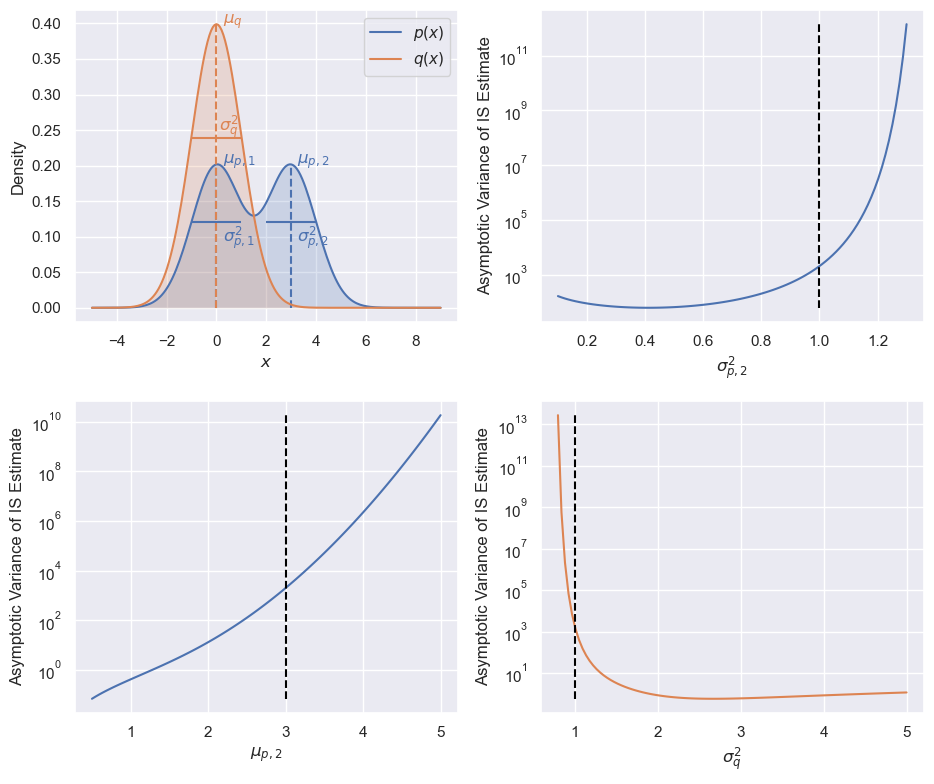

In [9]:
x_offset = 0.25

f, axs = plt.subplots(2, 2, figsize=(9.5, 8))

axs[0, 0].plot(linspace, p, label="$p(x)$")
axs[0, 0].fill_between(linspace, p, np.zeros_like(p), alpha=0.2)
axs[0, 0].vlines(x=p_args["mus"][0], ymin=0, ymax = mixture_of_gaussian(p_args["mus"][0], **p_args), colors="C0", linestyles="dashed")
axs[0, 0].hlines(y=float(mixture_of_gaussian(p_args["mus"][0], **p_args)) / 5 * 3, 
           xmin=p_args["mus"][0] - p_args["sigmas"][0], 
           xmax=p_args["mus"][0] + p_args["sigmas"][0], colors="C0")
axs[0, 0].text(x=p_args["mus"][0] + x_offset, y=mixture_of_gaussian(p_args["mus"][0], **p_args), s="$\mu_{p, 1}$", color="C0", zorder=99)
axs[0, 0].text(x=p_args["mus"][0] + x_offset, y=float(mixture_of_gaussian(p_args["mus"][0], **p_args)) / 2.2, s="$\sigma^2_{p, 1}$", color="C0", zorder=99)
axs[0, 0].vlines(x=p_args["mus"][1], ymin=0, ymax = mixture_of_gaussian(p_args["mus"][1], **p_args), colors="C0", linestyles="dashed")
axs[0, 0].hlines(y=float(mixture_of_gaussian(p_args["mus"][1], **p_args)) / 5 * 3, 
           xmin=p_args["mus"][1] - p_args["sigmas"][1], 
           xmax=p_args["mus"][1] + p_args["sigmas"][1], colors="C0")
axs[0, 0].text(x=p_args["mus"][1] + x_offset, y=mixture_of_gaussian(p_args["mus"][1], **p_args), s="$\mu_{p, 2}$", color="C0", zorder=99)
axs[0, 0].text(x=p_args["mus"][1] + x_offset, y=float(mixture_of_gaussian(p_args["mus"][1], **p_args)) / 2.2, s="$\sigma^2_{p, 2}$", color="C0", zorder=99)
axs[0, 0].plot(linspace, q, label="$q(x)$")
axs[0, 0].fill_between(linspace, q, np.zeros_like(q), alpha=0.2)
axs[0, 0].vlines(x=q_args["mus"][0], ymin=0, ymax = mixture_of_gaussian(q_args["mus"][0], **q_args), colors="C1", linestyles="dashed")
axs[0, 0].hlines(y=float(mixture_of_gaussian(q_args["mus"][0], **q_args)) / 5 * 3, 
           xmin=q_args["mus"][0] - q_args["sigmas"][0], 
           xmax=q_args["mus"][0] + q_args["sigmas"][0], colors="C1")
axs[0, 0].text(x=q_args["mus"][0] + x_offset, y=mixture_of_gaussian(q_args["mus"][0], **q_args), s="$\mu_{q}$", color="C1", zorder=99)
axs[0, 0].text(x=q_args["mus"][0] + x_offset / 3, y=float(mixture_of_gaussian(q_args["mus"][0], **q_args)) / 5 * 3.1, s="$\sigma^2_{q}$", color="C1", zorder=99)
axs[0, 0].set_ylabel("Density")
axs[0, 0].set_xlabel("$x$")
axs[0, 0].legend()

axs[0, 1].plot(p_sigma_ablation, p_sigma_ablation_variances, color="C0")
axs[0, 1].set_yscale("log")
axs[0, 1].set_ylabel("Asymptotic Variance of IS Estimate")
axs[0, 1].vlines(x=p_args["sigmas"][1], ymin=np.min(p_sigma_ablation_variances), ymax=np.max(p_sigma_ablation_variances), linestyle="dashed", color="black")
axs[0, 1].set_xlabel("$\sigma^2_{p, 2}$")

axs[1, 0].plot(mu_ablation, mu_ablation_variances, color="C0")
axs[1, 0].set_yscale("log")
axs[1, 0].set_ylabel("Asymptotic Variance of IS Estimate")
axs[1, 0].vlines(x=p_args["mus"][1], ymin=np.min(mu_ablation_variances), ymax=np.max(mu_ablation_variances), linestyle="dashed", color="black")
axs[1, 0].set_xlabel("$\mu_{p, 2}$")

axs[1, 1].plot(q_sigma_ablation, q_sigma_ablation_variances, color="C1")
axs[1, 1].set_yscale("log")
axs[1, 1].set_ylabel("Asymptotic Variance of IS Estimate")
axs[1, 1].vlines(x=q_args["sigmas"][0], ymin=np.min(q_sigma_ablation_variances), ymax=np.max(q_sigma_ablation_variances), linestyle="dashed", color="black")
axs[1, 1].set_xlabel("$\sigma^2_{q}$")

plt.tight_layout()
plt.savefig(os.path.join("additional_plots", "variance.pdf"))
plt.show()